In [1]:
import os
import pandas as pd
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [72]:
data = pd.read_sql("select * from sports_data.tourney_games_with_season_stats", conn)

In [73]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [74]:
predictor_columns = data.columns[8:-1]
predictors = data[predictor_columns]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [75]:
predictors_and_response.corr(numeric_only=True)['Win_Loss_Flag'].sort_values(ascending=False)

Win_Loss_Flag                                  1.000000
adj_offense_team                               0.270970
adj_defense_opponent                           0.225174
offensive_efficiency_team                      0.196490
opponent_offensive_efficiency_opponent         0.123610
effective_fg_percent_team                      0.116454
opponent_effective_fg_percent_opponent         0.112050
turnover_percent_opponent                      0.106504
offensive_rebound_percent_team                 0.104910
opponent_free_throw_rate_opponent              0.070684
free_throw_rate_opponent                       0.066086
opponent_turnover_percent_team                 0.033527
opponent_offensive_rebound_percent_opponent    0.001040
opponent_offensive_rebound_percent_team       -0.001040
opponent_turnover_percent_opponent            -0.033527
free_throw_rate_team                          -0.066086
opponent_free_throw_rate_team                 -0.070684
offensive_rebound_percent_opponent            -0

In [76]:
corrs = predictors_and_response.corr(numeric_only=True)['Win_Loss_Flag']
corrs = corrs[corrs > 0.02]
corrs = corrs[corrs.index != 'Win_Loss_Flag']
effective_predictors = corrs.index.tolist()

In [77]:
len(effective_predictors)

11

In [78]:
prediction_data = data[effective_predictors]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [79]:
prediction_data_normalized

,adj_offense_team,offensive_efficiency_team,effective_fg_percent_team,offensive_rebound_percent_team,opponent_turnover_percent_team,adj_defense_opponent,turnover_percent_opponent,free_throw_rate_opponent,opponent_offensive_efficiency_opponent,opponent_effective_fg_percent_opponent,opponent_free_throw_rate_opponent
0,-0.927835,-1.624681,-1.649647,-0.387095,0.617680,-0.591715,-0.114575,-0.058197,-0.464621,0.068223,-0.223741
1,-0.212381,-0.766889,-0.859129,0.315748,1.201215,-0.385921,-0.239694,-0.604433,-0.172103,-0.505183,0.359243
2,-0.195177,-0.715680,-0.196766,-0.101264,0.512527,-0.642958,0.836021,-0.578729,-0.571980,-0.983478,1.185184
3,1.053736,0.897114,0.248055,1.953495,0.069976,-0.749431,0.594703,0.817571,-0.412882,-0.499381,1.303525
4,-0.195177,-0.715680,-0.196766,-0.101264,0.512527,-0.790995,0.111636,-0.887965,-0.300158,-0.272603,-0.055341
...,...,...,...,...,...,...,...,...,...,...,...
1237,-1.426319,-0.604308,-0.281490,-0.531916,0.416185,0.157309,-0.374213,0.576946,0.324425,0.265386,1.252496
1238,0.367438,0.559941,1.489443,-1.255623,0.119701,0.328140,0.726266,1.420357,-0.523980,-0.440797,-0.824305
1239,-1.387000,-1.206570,-0.153137,-2.031117,-0.428632,-0.632140,0.312622,1.204664,-1.084201,-1.145650,-0.827130
1240,0.519922,0.775015,0.189707,0.712305,0.844513,0.025232,0.429733,0.886730,0.583046,0.949030,0.558894


In [80]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [81]:
data['predicted_outcome'] = clf.predict(prediction_data_normalized)

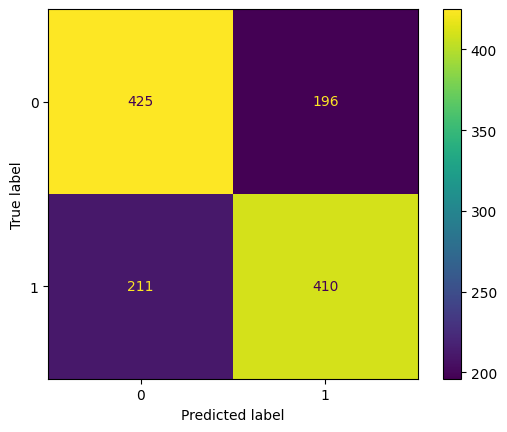

In [82]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], data['predicted_outcome'])).plot()

Logistic regression predicted 835 games correctly and got 407 wrong. Getting about 2/3 of the games right is not bad, but it's not great either. Other models might yield better results.

In [83]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, max_iter=3000).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [84]:
data['nn_predicted_outcome'] = clf.predict(prediction_data_normalized)

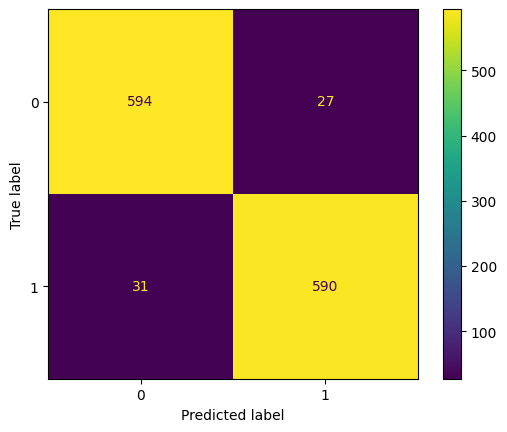

In [85]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], data['nn_predicted_outcome'])).plot()

NN did a lot better but there's probably some overfitting happening. Need to hold out a test set.

In [86]:
train_X = prediction_data_normalized.iloc[:int(len(prediction_data_normalized)*0.6)]
train_y = data['Win_Loss_Flag'].iloc[:int(len(prediction_data_normalized)*0.6)]
test_X = prediction_data_normalized.iloc[int(len(prediction_data_normalized)*0.6):]
test_y = data['Win_Loss_Flag'].iloc[int(len(prediction_data_normalized)*0.6):]

In [87]:
clf = MLPClassifier(hidden_layer_sizes=[50, 50, 50],random_state=0, max_iter=3000).fit(train_X, train_y)

In [88]:
nn_test_outcomes = clf.predict(test_X)

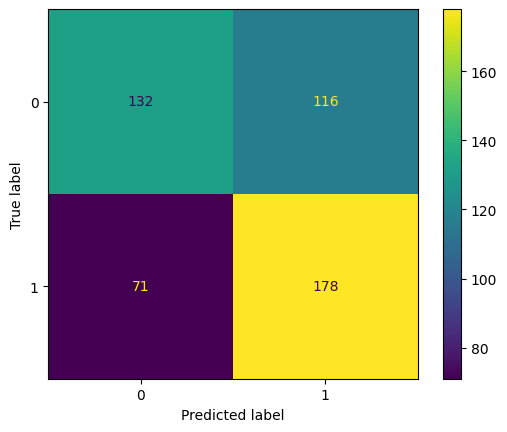

In [89]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(test_y, nn_test_outcomes)).plot()

In [38]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [91]:
cms = proper_cross_validation(MLPClassifier(hidden_layer_sizes=[50, 50, 50],random_state=0, max_iter=3000), prediction_data_normalized, data['Win_Loss_Flag'])

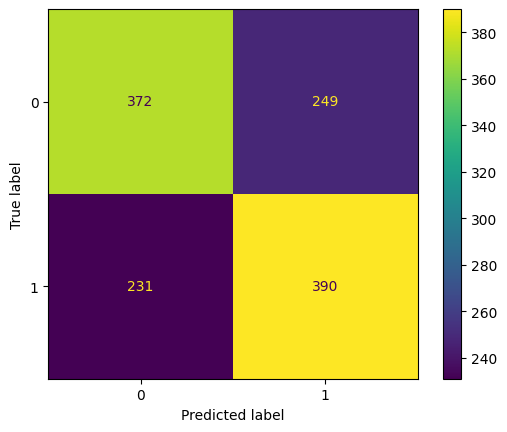

In [92]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

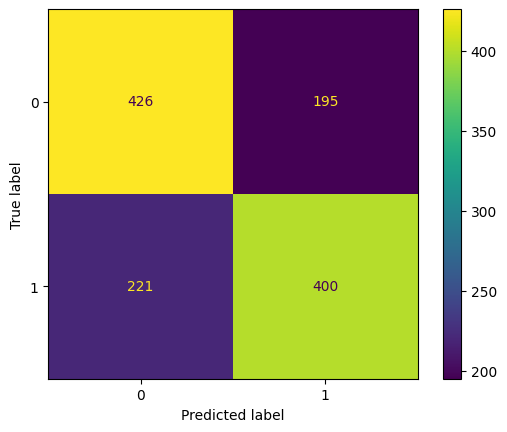

In [93]:
# and what about the logistic regression model?
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [94]:
# well, they're both getting things right a little under 70% of the time
# could try different models, but better indicators is probably the more effective way to go
all_games = pd.read_sql("select * from sports_data.game_stats_v2", conn)

In [95]:
all_games.columns

Index(['date', 'game_type', 'team', 'conference', 'opponent', 'location',
       'result', 'adj_offense', 'adj_defense', 'offensive_efficiency',
       'effective_fg_percent', 'turnover_percent', 'offensive_rebound_percent',
       'free_throw_rate', 'opponent_offensive_efficiency',
       'opponent_effective_fg_percent', 'opponent_turnover_percent',
       'opponent_offensive_rebound_percent', 'opponent_free_throw_rate',
       'opponent_conference', 'season', 'Win_Loss', 'score', 'opponent_score'],
      dtype='object')

In [96]:
team_conference_affiliation = all_games[['team', 'conference', 'season']].drop_duplicates(subset=['team', 'season'], keep='first')

In [97]:
len(data.columns)

35

In [99]:
data = pd.merge(data, team_conference_affiliation, left_on=['team', 'season'], right_on=['team', 'season'])

In [101]:
data['conference']

0       P12
1       B12
2       SEC
3        BE
4       SEC
       ... 
1237     SC
1238    MVC
1239    MWC
1240    P12
1241     BE
Name: conference, Length: 1242, dtype: object

In [13]:
data = pd.read_sql("select * from sports_data.tourney_games_v3", conn)

In [14]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [15]:
data.drop(columns=['losses', 'wins', 'losses_opponent', 'wins_opponent', 'conference'], inplace=True)

In [17]:
data

,opponent,season,last_10_win_loss_ratio_opponent,team,last_10_win_loss_ratio,date,location,Win_Loss,score,opponent_score,...,opponent_offensive_efficiency_opponent,opponent_effective_fg_percent_opponent,opponent_turnover_percent_opponent,opponent_offensive_rebound_percent_opponent,opponent_free_throw_rate_opponent,win_loss_ratio,win_loss_ratio_opponent,conference_strength,conference_strength_opponent,Win_Loss_Flag
0,Abilene Christian,2019,0.8,Kentucky,0.9,3/21/19,N,W,79,44,...,96.751724,49.755172,23.303448,27.431034,38.944828,0.810811,0.766667,0.710660,0.245902,1
1,Abilene Christian,2021,0.8,Texas,0.6,3/20/21,N,L,52,53,...,86.391304,45.226087,26.569565,27.539130,44.765217,0.703704,0.800000,0.763441,0.146341,0
2,Abilene Christian,2021,0.8,UCLA,0.5,3/22/21,N,W,67,47,...,86.391304,45.226087,26.569565,27.539130,44.765217,0.687500,0.800000,0.746988,0.146341,1
3,Abilene Christian,2022,0.8,Middle Tennessee,0.7,3/22/22,N,W,85,69,...,95.527586,51.372414,28.451724,31.179310,49.624138,0.685714,0.656250,0.528662,0.463235,1
4,Abilene Christian,2022,0.8,Ohio,0.5,3/21/22,N,L,86,91,...,95.527586,51.372414,28.451724,31.179310,49.624138,0.705882,0.656250,0.434783,0.463235,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,Xavier,2023,0.7,Texas,0.5,3/24/23,N,W,83,71,...,102.920588,50.597059,16.452941,24.808824,27.470588,0.763158,0.729730,0.797297,0.681159,1
1238,Yale,2016,0.9,Baylor,0.4,3/17/16,N,L,75,79,...,94.229630,46.474074,18.118519,24.262963,34.025926,0.636364,0.758621,0.788732,0.500000,0
1239,Yale,2016,0.9,Duke,0.7,3/19/16,N,W,71,64,...,94.229630,46.474074,18.118519,24.262963,34.025926,0.694444,0.758621,0.771028,0.500000,1
1240,Yale,2019,0.7,LSU,0.8,3/21/19,N,W,79,74,...,100.053571,47.364286,15.185714,24.160714,30.892857,0.800000,0.724138,0.710660,0.545455,1


In [20]:
predictor_columns = data.columns[10:-1]
predictor_columns = predictor_columns.tolist()
predictor_columns.append('last_10_win_loss_ratio_opponent')
predictor_columns.append('last_10_win_loss_ratio')
predictors = data[predictor_columns]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [30]:
corrs = predictors_and_response.corr(numeric_only=True)['Win_Loss_Flag']
corrs = corrs[corrs > 0.02]
corrs = corrs[corrs.index != 'Win_Loss_Flag']
effective_predictors = corrs.index.tolist()

In [31]:
effective_predictors.append('last_10_win_loss_ratio_opponent')

In [32]:
prediction_data = data[effective_predictors]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [33]:
prediction_data_normalized

,adj_offense_team,offensive_efficiency_team,effective_fg_percent_team,offensive_rebound_percent_team,opponent_turnover_percent_team,adj_defense_opponent,turnover_percent_opponent,free_throw_rate_opponent,opponent_offensive_efficiency_opponent,opponent_effective_fg_percent_opponent,opponent_free_throw_rate_opponent,win_loss_ratio,conference_strength,last_10_win_loss_ratio,last_10_win_loss_ratio_opponent
0,0.781728,0.619780,0.225327,1.341685,-0.283070,0.973251,-0.114126,-0.027956,-0.218814,0.723214,1.185079,0.886114,0.488963,1.195339,0.593551
1,0.270563,-0.507635,0.224453,-0.013105,-0.549432,-0.755867,1.166522,-0.021087,-2.429990,-1.085612,2.160624,-0.117158,0.819796,-0.610025,0.593551
2,0.363218,-0.244000,-0.184903,-0.172440,-0.554166,-0.755867,1.166522,-0.021087,-2.429990,-1.085612,2.160624,-0.268938,0.716668,-1.211813,0.593551
3,-1.173776,-0.856314,-0.547952,-0.193147,0.759587,0.361628,0.062140,0.879005,-0.480076,1.369108,2.975019,-0.285665,-0.651802,-0.008237,0.593551
4,-1.374533,-0.561586,-0.667665,-1.014785,0.652067,0.361628,0.062140,0.879005,-0.480076,1.369108,2.975019,-0.096751,-1.240243,-1.211813,0.593551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,0.377764,-0.030282,-0.048747,-0.700109,1.561208,0.427543,0.102141,-0.728114,1.097778,1.059447,-0.738098,0.439749,1.032009,-1.211813,-0.008237
1238,0.940021,0.549188,-0.331715,2.102660,0.336703,-0.157032,1.468484,1.589487,-0.757093,-0.587191,0.360630,-0.747933,0.978324,-1.813601,1.195339
1239,1.555440,1.638205,0.425551,0.661335,-0.623685,-0.157032,1.468484,1.589487,-0.757093,-0.587191,0.360630,-0.203890,0.867352,-0.008237,1.195339
1240,0.928993,0.562242,-0.231264,1.444202,0.662323,1.173152,0.291484,-0.835667,0.485884,-0.231658,-0.164498,0.784849,0.488963,0.593551,-0.008237


In [34]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [35]:
data['predicted_outcome'] = clf.predict(prediction_data_normalized)

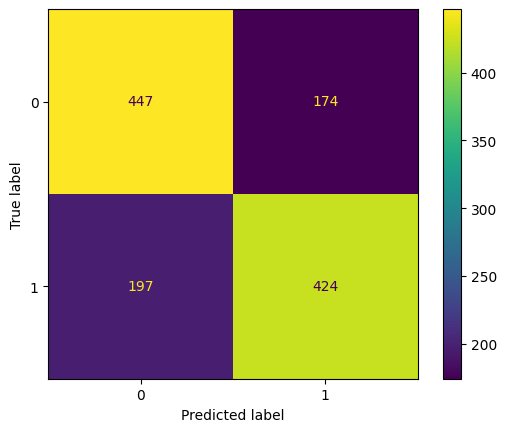

In [36]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], data['predicted_outcome'])).plot()

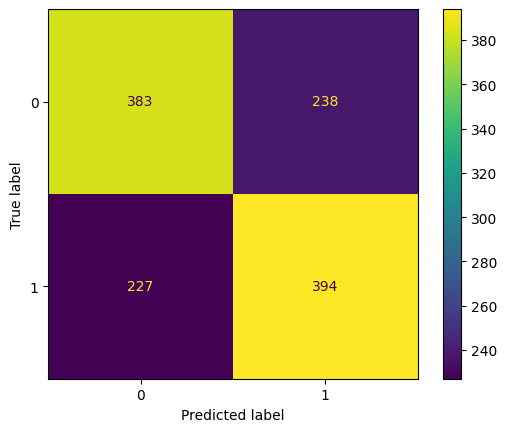

In [40]:
from sklearn.neural_network import MLPClassifier
cms = proper_cross_validation(MLPClassifier(hidden_layer_sizes=[50, 50, 50], max_iter=3000), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

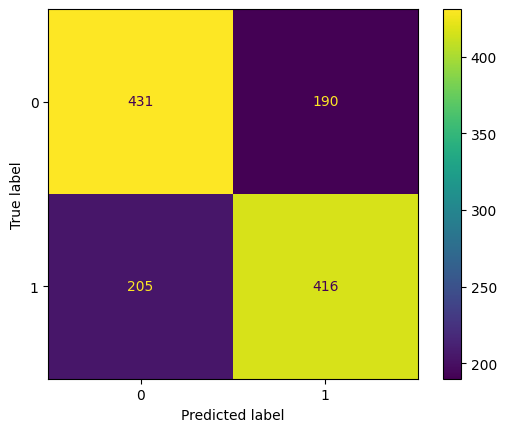

In [41]:
cms = proper_cross_validation(LogisticRegression(), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

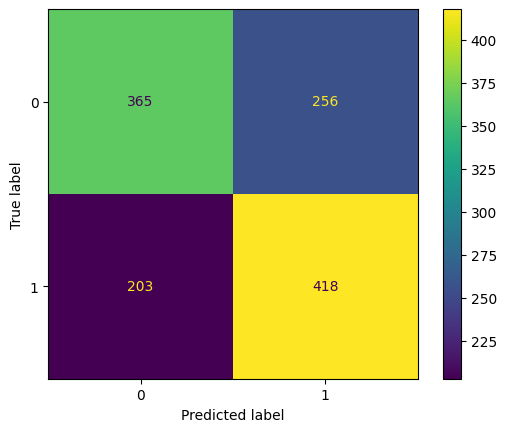

In [42]:
cms = proper_cross_validation(MLPClassifier(hidden_layer_sizes=[100, 100], max_iter=3000), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

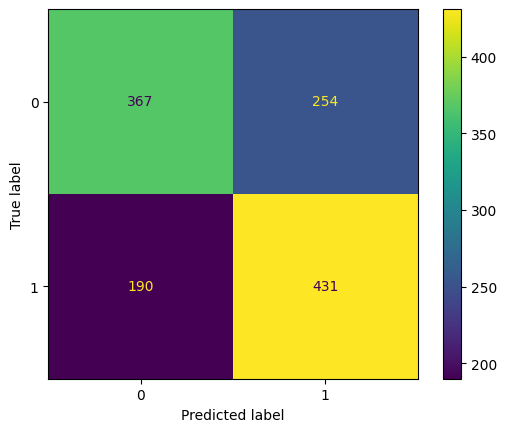

In [44]:
from sklearn.ensemble import RandomForestClassifier
cms = proper_cross_validation(LogisticRegression(), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=14)
pca.fit(prediction_data_normalized)
pd.DataFrame(pca.transform(prediction_data_normalized))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.642349,-0.963491,0.406474,1.160183,-0.078791,-0.953892,-0.100909,-0.850323,1.144661,-0.188331,-0.000487,0.281982,0.381578,0.547030
1,-0.652632,2.619134,1.576404,-0.555055,-1.230981,0.177950,0.519643,-0.735857,1.497164,-0.066756,0.083621,-0.061268,0.684435,0.723696
2,-0.382889,2.679274,1.560603,-0.687093,-1.587902,0.145352,0.623618,-0.686996,1.406956,0.230178,0.133235,-0.277233,0.198763,0.905928
3,1.469149,0.138785,1.990385,0.860195,0.463204,-1.052738,1.931536,-1.160488,0.965518,-0.333082,0.979840,0.175294,0.358194,0.548156
4,1.962117,0.205275,2.130641,0.069997,0.434932,-1.068068,2.308092,-0.948224,0.711924,0.216389,1.226136,-0.731602,-0.115996,0.825364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,0.404211,-1.374115,-1.200363,0.232153,-0.676092,0.933140,1.326347,1.353225,0.453093,0.348545,0.471381,-0.514237,-0.248462,-0.236495
1238,-0.573033,1.439564,1.107267,1.462307,-2.676131,-0.960989,-0.233925,1.110398,0.125554,1.586021,0.278008,0.253508,0.068698,0.066828
1239,-2.281676,0.847827,1.537319,0.151205,-1.393951,-1.007139,-0.461072,1.172605,0.261494,0.549581,-0.056236,0.690969,-0.529617,0.224372
1240,-1.076991,-1.015802,-0.592684,1.570958,-0.229874,0.293136,-0.494165,-0.014975,0.924566,0.560629,-0.901725,-0.137152,-0.082103,0.076466


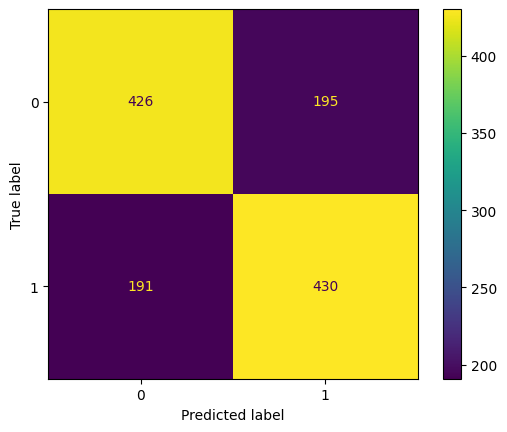

In [72]:
from sklearn.ensemble import AdaBoostClassifier
cms = proper_cross_validation(LogisticRegression(), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [63]:
(426+430)/1242

0.6892109500805152